# Practice Session 01: Find near-duplicates using shingling

Author: <font color="blue">Marc Pérez Pratdesaba</font>

E-mail: <font color="blue">marc.perez12@estudiant.upf.edu</font>

Date: <font color="blue">26/10/2022</font>

In this practice we take a large corpus of tweets and detect near-duplicates on this corpus using a technique known as *shingling*.

Two documents are considered near-duplicates if they share a large amount of ngrams. The *ngrams* of a phrase are overlapping sequences of words of length *n*. For instance, the phrase '*Never let them guess your next move.*' has the following 3-grams:

* 'never let them'
* 'let them guess'
* 'them guess your'
* 'guess your next'
* 'your next move'

To measure the similarity between two sets, we will use the [Jaccard index](https://en.wikipedia.org/wiki/Jaccard_index), which is the size of the intersection of the two sets divided by their union. This values goes between 0.0 (meaning the documents have no ngrams in common) to 1.0 (meaning the documents have the same ngrams).

To speed up things, instead of comparing the set of shingles of two documents which can be large, we will derive a fixed-length *signature* or *sketch* for each document. This will be obtained by (1) applying a random permutation to the list of possible ngrams, and (2) pick the ngram that appears first in the permuted list. The Jaccard index between these signatures will be a good approximation of the Jaccard index between the original sets of ngrams. 

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [34]:
import io
import json
import gzip
import re
import random
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer
import datetime

In [35]:
# Input file
INPUT_FILENAME = "CovidLockdownCatalonia.json.gz"

# Array for storing messages
messages = []
MAX_MESSAGES = 10000

with gzip.open(INPUT_FILENAME, "rt", encoding="utf-8") as input_file:
    
    messages_read = 0
    for line in input_file:
            
        # Read message
        tweet = json.loads(line)

        # Keep only messages in Catalan
        if tweet["lang"] == "ca":
            
            messages_read += 1
            
            if messages_read <= MAX_MESSAGES:
                author = tweet["user"]["screen_name"]
                message = tweet["full_text"]
                messages.append(message)

print("Read %d documents" % len(messages))

Read 10000 documents


# 1. Auxiliary functions

In [36]:
def jaccard_similarity(list1, list2):
    if (len(list1) > 0) and (len(list2) > 0):
        set1 = set(list1)
        set2 = set(list2)

        union_set = set1.union(set2)
        intersection_set = set1.intersection(set2)

        jac_sim = len(intersection_set)/len(union_set)
        
        return jac_sim
    return 0

In [37]:
#Examples of the function

ex1 = [1, 2]
ex2 = [1, 2, 3]
print(f"Array similarity is {jaccard_similarity(ex1, ex2)}")

ex3 = [1, 2, 3]
ex4 = [1, 2, 3, 4]
print(f"Array similarity is {jaccard_similarity(ex3, ex4)}")

ex5 = [1, 2, 3]
ex6 = [1, 2, 3]
print(f"Array similarity is {jaccard_similarity(ex5, ex6)}")

ex7 = [1, 2, 3]
ex8 = [4, 5, 6]
print(f"Array similarity is {jaccard_similarity(ex7, ex8)}")

Array similarity is 0.6666666666666666
Array similarity is 0.75
Array similarity is 1.0
Array similarity is 0.0


In [38]:
#Function that cleans messages

def clean(array):
    low_arr = array.lower() #converting to lowercase
    no_rt = low_arr.lstrip("rt") #remove rt sufix
    no_http = re.sub("http\S+", "", no_rt) #replace http
    no_https = re.sub("https\S+", "", no_http) #replace https
    romantisize_arr = no_https.replace("ñ", "n").replace("ó", "o").replace("ò", "o").replace("à", "a").replace("á", "a").replace("í", "i").replace("é", "e").replace("è", "e").replace("ï", "i").replace("l·l", "ll").replace("ü", "u") #romanize
    no_remains_arr = re.sub(r"[^a-zA-Z0-9 ]+", "",  romantisize_arr) #remove character that is not letter or digit
    single_space_arr = " ".join(no_remains_arr.split()) #replace multiple spaces to single space
    return single_space_arr

In [39]:
#Some examples of the method working

t1 = "RT Wàter!mél????oÑ   ___???123"
t2 = "RT PiÑA  CòladÁ???!"
t3 = "https://t.co/mzSc5Y5VxK"
t4 = "Però tenim un dubte! 🤔"
t5 = "EL  matÍ___??? increïblè?? vida"

test = [t1, t2, t3, t4, t5]

for t in test:
    print(f"Original string: {t}")
    print(f"Clean string: {clean(t)}\n")

Original string: RT Wàter!mél????oÑ   ___???123
Clean string: watermelon 123

Original string: RT PiÑA  CòladÁ???!
Clean string: pina colada

Original string: https://t.co/mzSc5Y5VxK
Clean string: 

Original string: Però tenim un dubte! 🤔
Clean string: pero tenim un dubte

Original string: EL  matÍ___??? increïblè?? vida
Clean string: el mati increible vida



# 2. Implement an n-gram extractor

In [40]:
MIN_TOKEN_LENGTH = 2

#Function that checks that all words have at least MIN_TOKEN_LENGTH

def words_to_consider(text):
    for i in text:
        if count_characters(i) < MIN_TOKEN_LENGTH:
            text.remove(i)
    return text

In [41]:
#Method that generate the n-grams

def ngrams(text, size):
    tokens = words_to_consider(clean(text).split())
    
    ngrams_list = []
    ngrams_res = []
    for i in range(len(tokens)-size+1):
        ngrams_list.append(tokens[i:i+size])
    
    for ngram in ngrams_list:
        ngrams_res.append(" ".join(ngram))
    return ngrams_res

In [42]:
print(messages[9780])
print(ngrams(messages[9780], 2))

RT @diariARA: Comerciants xinesos donen mascaretes i gel antisèptic a Badalona per lluitar contra el coronavirus https://t.co/ybYXFxphIu
['diariara comerciants', 'comerciants xinesos', 'xinesos donen', 'donen mascaretes', 'mascaretes gel', 'gel antiseptic', 'antiseptic badalona', 'badalona per', 'per lluitar', 'lluitar contra', 'contra el', 'el coronavirus']


# 3. Estimation for brute force method

In [43]:
def time_brute_force_similarities(messages, limit, ngram_size):
    if limit > len(messages):
        raise ValueError("Limit should be less than or equal than the number of messages")
        
    # Start a timer
    start = timer()

    # Iterate through document identifiers
    for docid1 in range(np.min([len(messages), limit])):

        # Clean document 1 and extract ngrams
        doc1 = clean(messages[docid1])
        ngrams1 = ngrams(doc1, ngram_size)

        # Iterate through document identifiers larger than doc2
        for docid2 in range(docid1+1, np.min([len(messages), limit])):
                         
            # Clean document 2 and extract ngrams
            doc2 = clean(messages[docid2])
            ngrams2 = ngrams(doc2, ngram_size)

            # Compute similarity
            similarity = jaccard_similarity(ngrams1, ngrams2)

    end = timer()
    return(end - start)

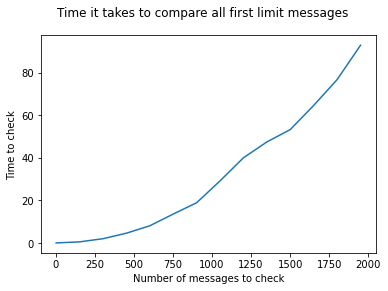

In [33]:
ngram_size = 3
limit = 10
x_range = list(range(1, 2001, 150))
y_time = []

for i in x_range:
    y_time.append(time_brute_force_similarities(messages[:i], i, ngram_size))

plt.plot(x_range, y_time)
plt.xlabel('Number of messages to check')
plt.ylabel('Time to check')
plt.suptitle("Time it takes to compare all first limit messages")
plt.show()

1) What we can see in this plot a quadratic tendency. We can also see that the function has two nested for loop with n iterations each. Therefore, we could say that it has complexity O(n^2). Hence, the more messages we check, the quadratically greater time we will need.
2) Taking into account that this plot lasted about 10-15 minutes to compare 2000 messages (ranging 150 every time), and the exponential tendency of the time, we could estimate that for the whole matrix it would take about 1 hour and 20 minutes approximately.

# 4. Computing the doc-ngram matrix

## 4.1 Create list of all ngrams

In [44]:
NGRAM_SIZE = 3

ngram_to_index = {}
index_to_ngram = {}
next_index = 0

for message in messages:
    all_ngrams = ngrams(message, NGRAM_SIZE)
    for ngram in all_ngrams:
        if ngram not in ngram_to_index:
            ngram_to_index[ngram] = next_index
            index_to_ngram[next_index] = ngram
            next_index +=1

num_distinct_ngrams = next_index

print("There are %d distinct ngrams in the %d documents" % (num_distinct_ngrams, len(messages)))

There are 67193 distinct ngrams in the 10000 documents


In [61]:
idx_tancat = ngram_to_index["tancat escoles fins"]
idx_garantir = ngram_to_index["garantir la seguretat"]
print(f'Ngram to index: {idx_tancat}, and index to ngram: {index_to_ngram[idx_tancat]}')
print(f'Ngram to index: {idx_garantir}, and index to ngram: {index_to_ngram[idx_garantir]}')

Ngram to index: 942, and index to ngram: tancat escoles fins
Ngram to index: 34, and index to ngram: garantir la seguretat


## 2.2 Create table ngrams x documents

In [62]:
# Create dense matrix in which every cell contains the value "False"
M_ngram_doc = np.full((num_distinct_ngrams, len(messages)), False)

# Print the number of rows and columns of this matrix
# numpy.matrix.shape is a tuple, shape[0] is the number of rows, shape[1] the number of columns
print("Matrix dimensions: %d rows (distinct shingles) x %d columns (distinct documents)" % M_ngram_doc.shape)

Matrix dimensions: 67193 rows (distinct shingles) x 10000 columns (distinct documents)


In [63]:
for docid in range(len(messages)):
    message = messages[docid]
    all_ngrams = ngrams(message, NGRAM_SIZE)
    for ngram in all_ngrams:
        M_ngram_doc[ngram_to_index[ngram]][docid] = True

In [67]:
num_cells = (M_ngram_doc.shape[0])*(M_ngram_doc.shape[1]) #num_cells = rows*columns
density = (np.count_nonzero(M_ngram_doc)/num_cells)*100
print(f'Density of the matrix: {round(density, 3)*100} %')

Density of the matrix: 2.3 %


In [70]:
print(f'Row 9602 is {M_ngram_doc[9602][:]}')
print(f'Row 941 is {M_ngram_doc[941][:]}\n')

#For row 9602
count_9602 = 0
for i in range(len(M_ngram_doc[9602][:])):
    if M_ngram_doc[9602][i] == True:
        count_9602 += 1
print(f'The number of non-zeros in row 9602 is {count_9602}')

#For row 941
count_941 = 0
for i in range(len(M_ngram_doc[941][:])):
    if M_ngram_doc[941][i] == True:
        count_941 += 1
print(f'The number of non-zeros in row 9602 is {count_941}')

Row 9602 is [False False False ... False False False]
Row 941 is [False False False ... False False False]

The number of non-zeros in row 9602 is 3
The number of non-zeros in row 9602 is 2


# 3. Implement a permutation generator

In [72]:
#Mehtod that creates a random permutation

def random_permutation(k):
    l = list(range(1, k))
    random.shuffle(l)
    return l

print(random_permutation(20))

[3, 7, 11, 4, 1, 18, 15, 13, 2, 8, 6, 9, 12, 16, 19, 14, 10, 17, 5]


In [73]:
# Permute a list according to a permutation
def permuter(original_list, permutation):
    permuted_list = []
    for index in permutation:
        permuted_list.append(original_list[index])
    return permuted_list

# Code for testing permutations
original_list_1 = ["1 (ek)", "2 (do)", "3 (tīn)", "4 (chār)", "5 (pāṅc)"]
original_list_2 = ["1 (jedan)", "2 (dva)", "3 (tri)", "4 (četiri)", "5 (pet)"]

print("Test one permutation:")
permutation_1 = random_permutation(5)
print(permuter(original_list_1, permutation_1))
print(permuter(original_list_2, permutation_1))

print()

print("Test another permutation")
permutation_2 = random_permutation(5)
print(permuter(original_list_1, permutation_2))
print(permuter(original_list_2, permutation_2))

Test one permutation:
['3 (tīn)', '5 (pāṅc)', '4 (chār)', '2 (do)']
['3 (tri)', '5 (pet)', '4 (četiri)', '2 (dva)']

Test another permutation
['3 (tīn)', '2 (do)', '5 (pāṅc)', '4 (chār)']
['3 (tri)', '2 (dva)', '5 (pet)', '4 (četiri)']


# 4. Compute the signature of each document

In [74]:
NUM_PERMUTATIONS = 5

permutations = []

# Create the permutations
for i in range(NUM_PERMUTATIONS):
    permutation = random_permutation(num_distinct_ngrams)
    permutations.append(random_permutation(num_distinct_ngrams))
    
# Visualize the permutations by printing their first 3 elements
for i in range(len(permutations)):
    permutation = permutations[i]
    print("Permutation %d: %d, %d, %d, ..." % (i, permutation[0], permutation[1], permutation[2] ))

Permutation 0: 60795, 55178, 37108, ...
Permutation 1: 22099, 13702, 64983, ...
Permutation 2: 5612, 34903, 41415, ...
Permutation 3: 4721, 58597, 13942, ...
Permutation 4: 43860, 16025, 27697, ...


In [75]:
M_signature_doc = np.full((NUM_PERMUTATIONS, len(messages)), np.nan)

# Find the first ngram in a document, according to a permutation
def find_first_one(docid, permutation):
    for shingle_id in permutation:
        if M_ngram_doc[shingle_id, docid] == True:
            return shingle_id
    return -1

# Create permutations
for permutation_num in range(NUM_PERMUTATIONS):
    print("Creating signatures for permutation %d/%d" % (permutation_num+1, NUM_PERMUTATIONS))
    permutation = permutations[permutation_num]
    for docid in range(len(messages)):
        if docid % 1000 == 0:
            print("- Scanning document %d of %d" % (docid, len(messages)))
        M_signature_doc[permutation_num][docid] = find_first_one(docid, permutation)

Creating signatures for permutation 1/5
- Scanning document 0 of 10000
- Scanning document 1000 of 10000
- Scanning document 2000 of 10000
- Scanning document 3000 of 10000
- Scanning document 4000 of 10000
- Scanning document 5000 of 10000
- Scanning document 6000 of 10000
- Scanning document 7000 of 10000
- Scanning document 8000 of 10000
- Scanning document 9000 of 10000
Creating signatures for permutation 2/5
- Scanning document 0 of 10000
- Scanning document 1000 of 10000
- Scanning document 2000 of 10000
- Scanning document 3000 of 10000
- Scanning document 4000 of 10000
- Scanning document 5000 of 10000
- Scanning document 6000 of 10000
- Scanning document 7000 of 10000
- Scanning document 8000 of 10000
- Scanning document 9000 of 10000
Creating signatures for permutation 3/5
- Scanning document 0 of 10000
- Scanning document 1000 of 10000
- Scanning document 2000 of 10000
- Scanning document 3000 of 10000
- Scanning document 4000 of 10000
- Scanning document 5000 of 10000
- Sca

In [76]:
# Leave this code as-is

def extract_ngrams(docid):
    return [x for x in range(num_distinct_ngrams) if M_ngram_doc[x, docid] == True]

def extract_signature(docid):
    return [M_signature_doc[x, docid] for x in range(NUM_PERMUTATIONS)]

def print_sig(messages, M_ngram_doc, M_signature_doc, i):
    print("Document #%d" % i)
    print("Message       : %s" % messages[i])
    print("Clean message : %s" % clean(messages[i]))
    print("Ngrams        : %s" % extract_ngrams(i))
    print("Signature     : %s" % extract_signature(i))

        
i = 385
j = 627

print_sig(messages, M_ngram_doc, M_signature_doc, i )

print()

print_sig(messages, M_ngram_doc, M_signature_doc, j )

Document #385
Message       : RT @gencat: 🔴 El @govern de la @gencat anuncia el #confinament de tot Catalunya.

Davant l’emergència de la #COVID19, el missatge és clau:…
Clean message : gencat el govern de la gencat anuncia el confinament de tot catalunyadavant lemergencia de la covid19 el missatge es clau
Ngrams        : [61, 3341, 3467, 4111, 4918, 4919, 4920, 4921, 4922, 4923, 4924, 4925, 4926, 4927, 4928, 4929, 4930, 4931]
Signature     : [4922.0, 4111.0, 4927.0, 4919.0, 4926.0]

Document #627
Message       : PROCICAT_CORONAVIRUS. El @govern de la @gencat anuncia el #confinament de tot Catalunya. Davant l’emergència de la #COVID19, el missatge és clau: limitar la mobilitat ajudarà a evitar la propagació del #coronavirus. Evitem desplaçaments i reduïm la vida social #JoEmQuedoACasa
Clean message : procicatcoronavirus el govern de la gencat anuncia el confinament de tot catalunya davant lemergencia de la covid19 el missatge es clau limitar la mobilitat ajudara a evitar la propagacio 

# 5. Compare all pairs of signatures

In [77]:
is_possible_duplicate = []

# Iterate through all documents
for docid1 in range(len(messages)):

     # Do not examine again a document that is a possible duplicate
    if docid not in is_possible_duplicate:

        # Counters for full and partial signature matches
        count_sig_full_matches = 0
        count_sig_partial_matches = 0

        # Extract the signature of the doc1
        signature1 = extract_signature(docid1)
        if docid1 % 500 == 0:
            print("%d/%d documents scanned" % (docid1, len(messages)))

        # Iterate through documents with docid larger than doc1
        for docid2 in range(docid1+1, len(messages)):

            # If this has not already been marked as duplicate of another document
            if docid2 not in is_possible_duplicate:

                # Extract signature of doc2
                signature2 = extract_signature(docid2)
                
                similarity = jaccard_similarity(signature1, signature2)
                if similarity == 1: # Check depending on the similarities
                    count_sig_full_matches += 1
                    is_possible_duplicate.append(docid2)
                elif 0.2 < similarity < 1:
                    count_sig_partial_matches += 1
                    is_possible_duplicate.append(docid2)
                    
        if (count_sig_partial_matches + count_sig_full_matches) > 50: # If it surpasses the limit, we include docid1 as possible duplicate
            print(f"Doc: {docid1} has {count_sig_partial_matches} partial matches and {count_sig_full_matches} full matches")
            is_possible_duplicate.append(docid1)


0/10000 documents scanned
Doc: 16 has 20 partial matches and 71 full matches
Doc: 42 has 28 partial matches and 24 full matches
Doc: 53 has 0 partial matches and 57 full matches
Doc: 166 has 0 partial matches and 56 full matches
Doc: 328 has 0 partial matches and 65 full matches
500/10000 documents scanned
1000/10000 documents scanned
1500/10000 documents scanned
2000/10000 documents scanned
2500/10000 documents scanned
3000/10000 documents scanned
3500/10000 documents scanned
4000/10000 documents scanned
4500/10000 documents scanned
5000/10000 documents scanned
Doc: 5077 has 3 partial matches and 176 full matches
Doc: 5109 has 0 partial matches and 66 full matches
Doc: 5117 has 0 partial matches and 71 full matches
Doc: 5129 has 0 partial matches and 54 full matches
Doc: 5271 has 0 partial matches and 54 full matches


One tweet that has a substantial number of complete matches, but few partial matches is the docid: 328

In [78]:
print(messages[328])

RT @QuimTorraiPla: Estem preparats per fer-ho. Cal que l’Estat accedeixi a aturar entrades i sortides als ports, aeroports i vies ferroviàr…


This is because this tweet does not refere to anything in particular. It is an answer from the president of Catalunya at the time for some question that someone may have made to him. If the tweet contained words like Covid or pandemic, it would have contained more partial matches.

One tweet that has a substantial number of partial matches, but few complete matches is the docid: 42

In [79]:
print(messages[42])

RT @VilaWeb: Els @mossos diuen que és més senzill confinar el Principat que diverses ciutats a la vegada https://t.co/piyLz82e9d


This tweet talks must contain ngrams that have usually been used at the time where Covid was very present. 